## Importando as bibliotecas utilizadas

In [47]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance as dist
from imutils.perspective import four_point_transform
from imutils import contours
import imutils

##Lembrar de verificar quais libs nao estao sendo utilizada

## Função auxiliar para printar a imagem na tela

In [48]:
def show_image(image):
    plt.figure()
    plt.imshow(image)

## Transformando a imagem de exemplo em preto e branco (ou nesse caso, amarelo e roxo)

In [82]:
def limpa_imagem_oper_morfol(image):
    #image = cv2.imread(caminho_imagem)
    #Transformando a imagem em escala de cinza
    gray_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Revelando regioes mais escuras (ou seja, os digitos) do que a regiao claras (o fundo)
    thresh = cv2.threshold(gray_scale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    #Foram testados diferentes valores para o kernel (2....9), sendo o 4 o melhor resultado
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1,4))

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
    return closing

### Com os filtros aplicados a imagem, vamos trabalhar em cima dela.

### Primeiro, aplicamos o filtro de contorno, em seguida, armazenamos o contorno dos digitos.
### Mostramos na tela os possiveis digitos contornados.

### Retorna uma imagem com os contornos dos possiveis dígitos e uma lista dos contornos dos dígitos

In [102]:
def encontra_digitos_image(imagem_transform_morfo):
    for_show_img_contor = imagem_transform_morfo.copy()
    #Aplicando o filtro de contorno e encontrando-os
    cnts = cv2.findContours(imagem_transform_morfo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    #Lista para armazenar os contornos dos digitos
    digitCnts = []

    #Loops nos candidatos da area de digitos
    for c in cnts:
        #Calcula a "caixa" de um possivel digito
        (x, y, w, h) = cv2.boundingRect(c)

        if(w > 10 and (h >= 30 and h <=40)):
        #if(w >= 10 and (h >= 3)):
            digitCnts.append(c)
            #Ultimo valor == espessura do retangulo
            #Pintando de verde (R, G, B)
            cv2.rectangle(for_show_img_contor, (x,y), (x+w, y+h), (255, 0, 0), 1)

    #Classificando os contos da esquerda para a direita (mesma direcao em que leriamos os digitos)
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
    return for_show_img_contor, digitCnts


## Com a lista de possiveis digitos feita, vamos agora identificar quais digitos são esses
### Temos um dicionário cuja a tupla é a chave de um digito em si. 
### A chave que indentificará qual é o possível dígito, é gerada dentro do for que caminha na lista de possíveis dígitos, calculando a altura e largura extraindo os sete segmentos do dígito. Verificando se determinado segmento está ligado ou não, e com base nisso, conseguindo identificar qual dígito ele é.

In [106]:
def classifica_digitos(image, imagem_limpa, lista_digitos):
    #image = cv2.imread(caminho_imagem_original)
    #Dicionario cujo a chave eh uma tupla que indica qual numero ele eh
    DIGITS_LOOKUP = {
        (1, 1, 1, 0, 1, 1, 1): 0,
        (0, 0, 1, 0, 0, 1, 0): 1,
        (1, 0, 1, 1, 1, 1, 0): 2,
        (1, 0, 1, 1, 0, 1, 1): 3,
        (0, 1, 1, 1, 0, 1, 0): 4,
        (1, 1, 0, 1, 0, 1, 1): 5,
        (1, 1, 0, 1, 1, 1, 1): 6,
        (1, 0, 1, 0, 0, 1, 0): 7,
        (1, 1, 1, 1, 1, 1, 1): 8,
        (1, 1, 1, 1, 0, 1, 1): 9
    }
    digits = []
    #Armazenando uma copia da imagem original em output, para mostrar a saida
    output = image.copy()
    #Loop em cada um dos digitos
    for c in lista_digitos:
        #Para cada uma das regioes, calculamos a caixa delimitadora e extraimos o digito ROI
        (x, y, w, h) = cv2.boundingRect(c)

        #Largura e altura aproximadas de cada segmento com base nas dimensoes do ROI
        roi = imagem_limpa[y:y + h, x:x + w]

        (roiH, roiW) = roi.shape
        (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
        dHC = int(roiH * 0.05)

        #Lista de (x, y) coordenadas que correspondem aos sete segmentos
        segments = [
            ((0, 0), (w, dH)),                           # top
            ((0, 0), (dW, h // 2)),                      # top-left
            ((w - dW, 0), (w, h // 2)),                  # top-right
            ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
            ((0, h // 2), (dW, h)),	                     # bottom-left
            ((w - dW, h // 2), (w, h)),                  # bottom-right
            ((0, h - dH), (w, h))                        # bottom
        ]

        #Lista que informa se determinado segmento esta ligado. Valor 0 == segmento desligado
        #[0, 0, 0, 0, 0, 0, 0]
        on_list = [0] * len(segments)

        #Loop sobre os segmentos
        for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
            #Extraindo o ROI do segmento
            segROI = roi[yA:yB, xA:xB]
            #Numero de pixels do segmento q estao "ligados"
            total = cv2.countNonZero(segROI)
            area = (xB - xA) * (yB - yA)


            #Se a proporcao de pixels diferentes de 0 para a area do segmento 
            #for maior que 50% => O segmento estao ligado

            if(total / float(area)) > 0.5:
                on_list[i] = 1

        #Obtendo o digito em si
        #print(tuple(on))
        digit = DIGITS_LOOKUP[tuple(on_list)]
        digits.append(digit)

        #Desenhando uma caixa em torno do digito e exibindo qual digito ele eh
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.putText(output, str(digit), (x+10,y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    return output, digits

# Executando o teste base

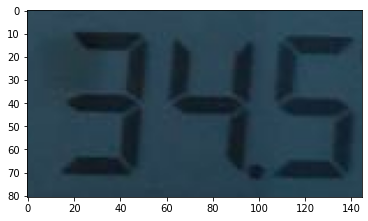

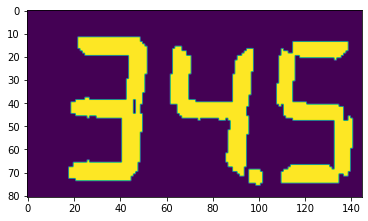

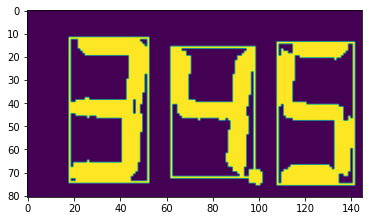

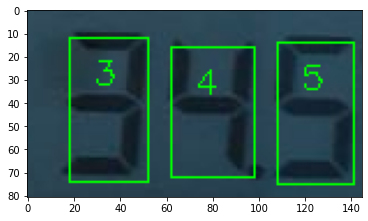

In [101]:
imagem_exemplo = "ex.png"
#Lendo a imagem
img = cv2.imread(imagem_exemplo)
show_image(img)

#Limpando a imagem
clean_image = limpa_imagem_oper_morfol(img)
show_image(clean_image)

#Encontrando os possiveis digitos
img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image)
show_image(img_possiveis_digitos)
#Identificando os possiveis digitos
resultado = classifica_digitos(img, clean_image, possiveis_digitos)
show_image(resultado)

## Dado que nem todas as imagens terão a mesma dimensão, é necessário uma função para identificar e recortar a parte de onde os dígitos estão

In [107]:
def cut_image(img):
    #image = cv2.imread(caminho_imagem)
    image = imutils.resize(img, height=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 200, 255)
    
    #show_image(edged)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        if(len(approx) == 4):
            displayCnt = approx
            break
    warped = four_point_transform(gray, displayCnt.reshape(4, 2))
    output = four_point_transform(image, displayCnt.reshape(4, 2))
    
    return output

# Executando a primeira base de testes

[3, 4, 5]


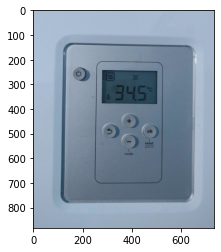

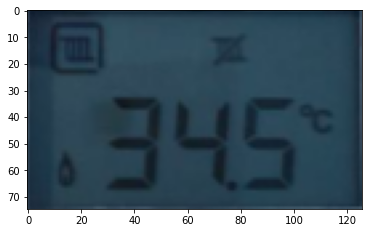

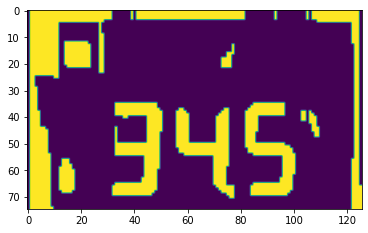

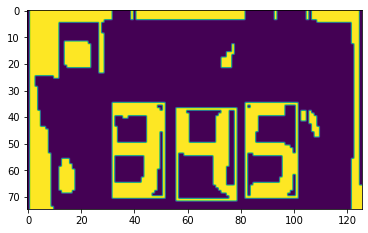

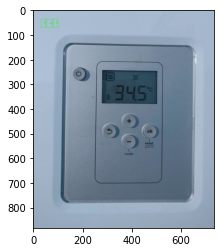

In [109]:
#imagem_exemplo = "./Base1/unnamed2.png"
imagem_exemplo = "./Base2/ex6.jpg"
#Lendo a imagem
img = cv2.imread(imagem_exemplo)
show_image(img)

#Cortando a imagem
imagem_cortada = cut_image(img)
show_image(imagem_cortada)

#Limpando a imagem
clean_image = limpa_imagem_oper_morfol(imagem_cortada)
show_image(clean_image)

#Encontrando os possiveis digitos
img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image)
show_image(img_possiveis_digitos)

#Identificando os possiveis digitos
res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos)
show_image(res_img)
print(res_digits)